In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import torch
from os.path import join
device = "cuda" if torch.cuda.is_available() else "cpu"

Try to study the RADIO base model (distilled from the giant model)

In [13]:
from PIL import Image
from io import BytesIO
import requests
import torch
from torch.nn import functional as F
from torchvision.transforms.functional import pil_to_tensor
# model_version="radio_v2.5-g" # for RADIOv2.5-g model (ViT-H/14)
# model_version="radio_v2.5-h" # for RADIOv2.5-H model (ViT-H/16)
# model_version="radio_v2.5-l" # for RADIOv2.5-L model (ViT-L/16)
model_version="radio_v2.5-b" # for RADIOv2.5-B model (ViT-B/16)
#model_version="e-radio_v2" # for E-RADIO
model = torch.hub.load('NVlabs/RADIO', 'radio_model', version=model_version, progress=True, skip_validation=True)
model.cuda().eval()

response = requests.get('https://github.com/NVlabs/RADIO/raw/main/assets/radio.png')
x = Image.open(BytesIO(response.content)).convert('RGB')
x = pil_to_tensor(x).to(dtype=torch.float32, device='cuda')
x.div_(255.0)  # RADIO expects the input values to be between 0 and 1
x = x.unsqueeze(0) # Add a batch dimension

nearest_res = model.get_nearest_supported_resolution(*x.shape[-2:])
x = F.interpolate(x, nearest_res, mode='bilinear', align_corners=False)

if "e-radio" in model_version:
    model.model.set_optimal_window_size(x.shape[2:]) #where it expects a tuple of (height, width) of the input image.

# RADIO expects the input to have values between [0, 1]. It will automatically normalize them to have mean 0 std 1.
summary, spatial_features = model(x)

# By default, RADIO will return the spatial_features in NLC format, with L being a combined height/width dimension.
# You can alternatively ask for the features in the more computer-vision-convenient format NCHW the following way:
summary, spatial_features = model(x, feature_fmt='NCHW')
assert spatial_features.ndim == 4

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


In [23]:
x.shape

torch.Size([1, 3, 304, 304])

In [19]:
nearest_res

Resolution(height=304, width=304)

In [22]:
type(model)

radio.radio_model.RADIOModel

In [21]:
model.get_nearest_supported_resolution(*x.shape[2:])

Resolution(height=304, width=304)

In [9]:
summary.shape

torch.Size([1, 2304])

In [10]:
spatial_features.shape

torch.Size([1, 768, 19, 19])

### Fetch features and understand feature structure

In [45]:
model.feature_normalizer

Identity()

In [48]:
print(model.model.patch_generator.num_cls_tokens) # number of cls tokens
print(model.num_cls_tokens)
print(model.summary_idxs) # indices of the summary tokens that provide the summary 
print(model.model.patch_generator.num_skip) # number of skip tokens, after which there are only spatial tokens
print(model.num_summary_tokens) # number of summary tokens

4
4
tensor([0, 1, 2], device='cuda:0')
8
8


In [ ]:
# the operation to bb summary
bb_summary.flatten(1)

### Fit encoding models for vision transformer

In [14]:
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import os
from os.path import join
import torch as th
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from circuit_toolkit.plot_utils import show_imgrid
from circuit_toolkit.layer_hook_utils import featureFetcher
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
from circuit_toolkit.plot_utils import saveallforms
from core.data_utils import load_neural_data, load_from_hdf5, parse_image_fullpaths
from core.model_load_utils import load_model_transform
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit

In [15]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"

In [16]:
stimuli_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli"
ephys_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"

data_path = join(ephys_root, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
# datapath_day3 = join(ephys_root, "vvs_accentuate_day3_normalize_red_20250123-20250126.hdf5")

imgdir_shared = join(stimuli_root, "shared1000")
imgdir = join(stimuli_root, "stimuli_pilot_20241119/results")
# imgdir_day3 = join(stimuli_root, "results_12-01-2025")
data = load_from_hdf5(data_path)
print("subjects:", list(data.keys()))

subjects: ['red_20241212-20241220']


In [17]:
subject_id = 'red_20241212-20241220'
data_dict = load_neural_data(data_path, subject_id, None)
data_dict['image_fps'] = parse_image_fullpaths(data_dict["stimulus_names"], [imgdir_shared, imgdir])
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
figdir = join(dataroot, subject_id, "model_outputs")
os.makedirs(figdir, exist_ok=True)

All stimulus files were found


In [24]:
from torchvision import transforms as T
from circuit_toolkit.layer_hook_utils import featureFetcher, recursive_print

In [26]:
recursive_print(model, deepest=3)

[RADIOModel]
(model): VisionTransformer
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential
    (0): Block
    (1): Block
    (2): Block
    (3): Block
    (4): Block
    (5): Block
    (6): Block
    (7): Block
    (8): Block
    (9): Block
    (10): Block
    (11): Block
  (norm): Identity()
  (fc_norm): Identity()
  (head_drop): Dropout(p=0.0, inplace=False)
  (head): Identity()
  (patch_generator): ViTPatchGenerator
    (im_to_patches): Im2Patches()
    (embedder): ViTPatchLinear(in_features=768, out_features=768, bias=False)
    (cls_token): ClsToken()
    (patch_normalizer): Identity()
(input_conditioner): InputConditioner()
(adaptors): ModuleDict()
(feature_normalizer): Identity()


In [29]:
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values() if ".model.blocks.Block" in name] #  if ".blocks.NestedTensorBlock" in name

In [30]:
module_names

['.model.blocks.Block0',
 '.model.blocks.Block1',
 '.model.blocks.Block2',
 '.model.blocks.Block3',
 '.model.blocks.Block4',
 '.model.blocks.Block5',
 '.model.blocks.Block6',
 '.model.blocks.Block7',
 '.model.blocks.Block8',
 '.model.blocks.Block9',
 '.model.blocks.Block10',
 '.model.blocks.Block11']

In [64]:
modelname = "radio_v2.5-b"

In [31]:
batch_size = 96
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
modelname = "radio_v2.5-b"  # for RADIOv2.5-B model (ViT-B/16)
model_version = modelname
resolution = (224, 224)
#model_version="e-radio_v2" # for E-RADIO
radio_model = torch.hub.load('NVlabs/RADIO', 'radio_model', version=model_version, progress=True, skip_validation=True)
radio_model = radio_model.eval().to(device)
radio_model.requires_grad_(False)
transforms_pipeline = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Prepare dataset with transforms
dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
# Prepare fetcher
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values() if ".model.blocks.Block" in name]
# Add hooks to all layers / blocks in resnet50
for name in module_names: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

# # Record features
feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()
th.cuda.empty_cache()

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

.model.blocks.Block0 torch.Size([1028, 204, 768])
.model.blocks.Block1 torch.Size([1028, 204, 768])
.model.blocks.Block2 torch.Size([1028, 204, 768])
.model.blocks.Block3 torch.Size([1028, 204, 768])
.model.blocks.Block4 torch.Size([1028, 204, 768])
.model.blocks.Block5 torch.Size([1028, 204, 768])
.model.blocks.Block6 torch.Size([1028, 204, 768])
.model.blocks.Block7 torch.Size([1028, 204, 768])
.model.blocks.Block8 torch.Size([1028, 204, 768])
.model.blocks.Block9 torch.Size([1028, 204, 768])
.model.blocks.Block10 torch.Size([1028, 204, 768])
.model.blocks.Block11 torch.Size([1028, 204, 768])
FeatureFetcher hooks all freed


### Neural Regression and prediction

In [54]:
import time
from neural_regress.regress_lib import transform_features2Xdict, sweep_regressors, MultiTaskLassoCV, MultiOutputSeparateLassoCV, RidgeCV

In [ ]:
# def get_cls_token(X):
#     return X[:, 0, :]

# def get_mean_register_token(X):
#     return X[:, 1:5, :].mean(dim=1)

# def get_maxpool_space_token(X):
#     return X[:, 5:, :].max(dim=1)[0]

# def get_avgpool_space_token(X):
#     return X[:, 5:, :].mean(dim=1)

# def get_cls_cat_maxpool_space_token(X):
#     return torch.cat([get_cls_token(X), get_maxpool_space_token(X)], dim=1)

In [59]:
summary_idxs = model.summary_idxs.cpu()
max_summary_idx = summary_idxs.max() + 1
num_skip = model.model.patch_generator.num_skip
num_cls_tokens = model.model.patch_generator.num_cls_tokens
def get_summary_flatten(X):
    return X[:, summary_idxs, :].flatten(1)

def get_extra_cls_flatten(X):
    return X[:, max_summary_idx:num_cls_tokens, :].flatten(1)

def get_cls_without_summary_flatten(X):
    return X[:, max_summary_idx:num_skip, :].flatten(1)

def get_maxpool_space_token(X):
    return X[:, num_skip:, :].max(dim=1)[0]

def get_avgpool_space_token(X):
    return X[:, num_skip:, :].mean(dim=1)


In [60]:
Xtransforms_dict = {
    "summary_token_flatten": get_summary_flatten,
    "extra_cls_token_flatten": get_extra_cls_flatten,
    "maxpool_space_token": get_maxpool_space_token,
    "avgpool_space_token": get_avgpool_space_token,
    "cls_without_summary_token_flatten": get_cls_without_summary_flatten,
}

In [61]:
Xdict_lyrswp = {}
Xtfmer_lyrswp = {}
for layer in module_names:
    for dimred_str, transform_func in Xtransforms_dict.items():
        t0 = time.time()
        Xdict_lyrswp[f"{layer}_{dimred_str}"] = transform_func(feat_dict_lyrswp[layer])
        Xtfmer_lyrswp[f"{layer}_{dimred_str}"] = transform_func
        print(f"Time taken to transform {layer} x {dimred_str}: {time.time() - t0:.3f}s")

Time taken to transform .model.blocks.Block0 x summary_token_flatten: 0.017s
Time taken to transform .model.blocks.Block0 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block0 x maxpool_space_token: 0.304s
Time taken to transform .model.blocks.Block0 x avgpool_space_token: 0.098s
Time taken to transform .model.blocks.Block0 x cls_without_summary_token_flatten: 0.000s
Time taken to transform .model.blocks.Block1 x summary_token_flatten: 0.002s
Time taken to transform .model.blocks.Block1 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block1 x maxpool_space_token: 0.235s
Time taken to transform .model.blocks.Block1 x avgpool_space_token: 0.055s
Time taken to transform .model.blocks.Block1 x cls_without_summary_token_flatten: 0.000s
Time taken to transform .model.blocks.Block2 x summary_token_flatten: 0.002s
Time taken to transform .model.blocks.Block2 x extra_cls_token_flatten: 0.000s
Time taken to transform .model.blocks.Block2 x maxpool

In [62]:
resp_mat_sel = resp_mat
# Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "avgtoken", "clstoken"],  #  "srp"
#                                                         pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV"] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

.model.blocks.Block0_summary_token_flatten RidgeCV D2_train: 0.080 D2_test: 0.040 time: 1.175
.model.blocks.Block0_extra_cls_token_flatten RidgeCV D2_train: 0.048 D2_test: 0.019 time: 0.382
.model.blocks.Block0_maxpool_space_token RidgeCV D2_train: 0.202 D2_test: 0.071 time: 0.268
.model.blocks.Block0_avgpool_space_token RidgeCV D2_train: 0.188 D2_test: 0.083 time: 0.259
.model.blocks.Block0_cls_without_summary_token_flatten RidgeCV D2_train: 0.108 D2_test: 0.033 time: 0.248
.model.blocks.Block1_summary_token_flatten RidgeCV D2_train: 0.237 D2_test: 0.118 time: 0.214
.model.blocks.Block1_extra_cls_token_flatten RidgeCV D2_train: 0.217 D2_test: 0.133 time: 0.257
.model.blocks.Block1_maxpool_space_token RidgeCV D2_train: 0.267 D2_test: 0.133 time: 0.265
.model.blocks.Block1_avgpool_space_token RidgeCV D2_train: 0.262 D2_test: 0.124 time: 0.261
.model.blocks.Block1_cls_without_summary_token_flatten RidgeCV D2_train: 0.268 D2_test: 0.120 time: 0.239
.model.blocks.Block2_summary_token_flatt

In [65]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

In [66]:
result_df_lyrswp

,,alpha,train_score,test_score,n_feat,runtime
.model.blocks.Block0_summary_token_flatten,RidgeCV,"[0.01, 0.1, 0.1, 1000.0, 0.01, 0.1, 0.1, 0.1, ...",0.080392,0.040476,2304,1.174546
.model.blocks.Block0_extra_cls_token_flatten,RidgeCV,"[0.01, 0.1, 1.0, 1000.0, 0.01, 0.1, 0.1, 1.0, ...",0.048299,0.019456,768,0.381608
.model.blocks.Block0_maxpool_space_token,RidgeCV,"[10.0, 10.0, 100.0, 100.0, 10.0, 10.0, 10.0, 1...",0.201574,0.071337,768,0.267924
.model.blocks.Block0_avgpool_space_token,RidgeCV,"[1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0, 1.0, 1.0...",0.188075,0.082974,768,0.258544
.model.blocks.Block0_cls_without_summary_token_flatten,RidgeCV,"[0.1, 1.0, 1.0, 100.0, 0.1, 1.0, 1.0, 1.0, 0.1...",0.107698,0.033031,3840,0.248014
.model.blocks.Block1_summary_token_flatten,RidgeCV,"[0.1, 0.1, 0.1, 10.0, 0.1, 0.1, 0.1, 0.1, 0.1,...",0.237471,0.11789,2304,0.213609
.model.blocks.Block1_extra_cls_token_flatten,RidgeCV,"[0.01, 0.01, 0.1, 1.0, 0.01, 0.1, 0.1, 0.1, 0....",0.216695,0.132988,768,0.257383
.model.blocks.Block1_maxpool_space_token,RidgeCV,"[10.0, 10.0, 10.0, 100.0, 10.0, 10.0, 10.0, 10...",0.26661,0.132568,768,0.264912
.model.blocks.Block1_avgpool_space_token,RidgeCV,"[0.1, 1.0, 1.0, 10.0, 0.1, 1.0, 1.0, 1.0, 1.0,...",0.261874,0.124412,768,0.261052
.model.blocks.Block1_cls_without_summary_token_flatten,RidgeCV,"[0.1, 1.0, 1.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.268069,0.119976,3840,0.239224


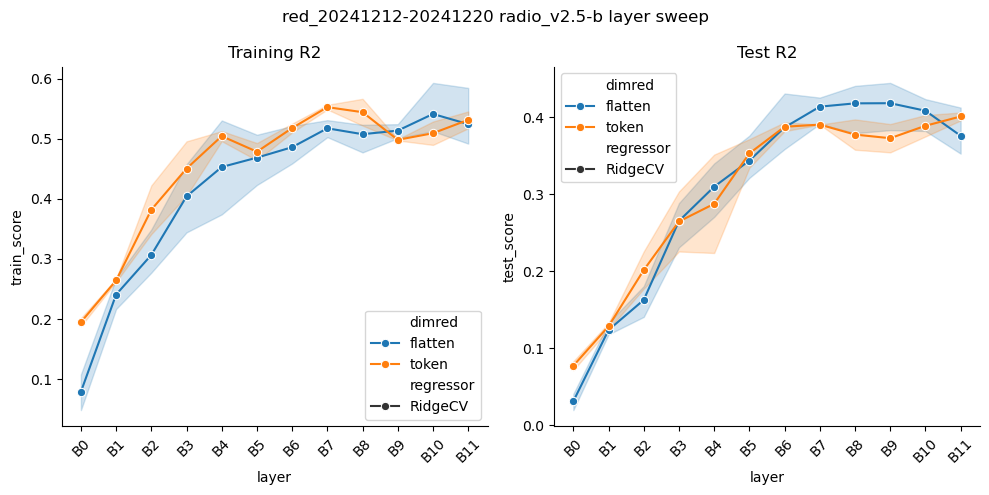

In [67]:
layer_shorten_func = lambda x: x.replace(".model.blocks.Block", "B")

figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()

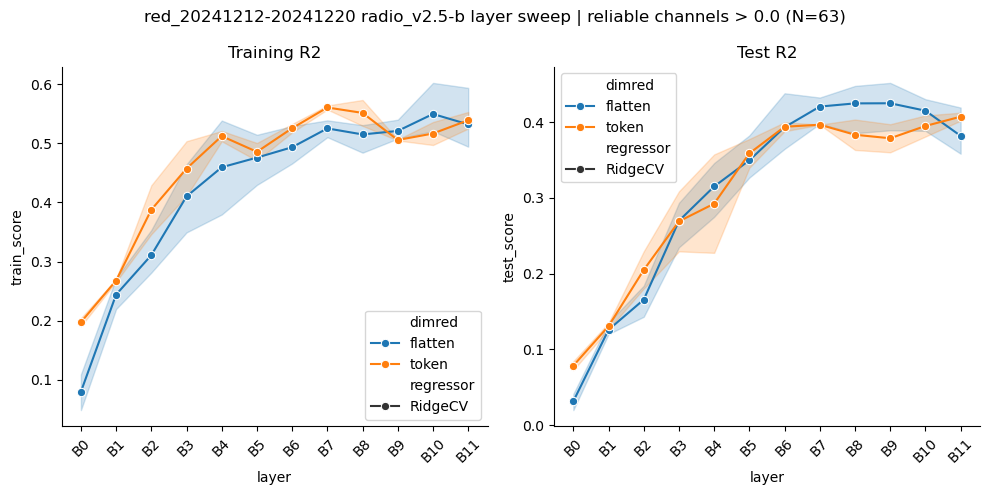

In [68]:
for thresh in [0.0]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    figh = plot_result_df_per_layer(result_df_masked, shorten_func=layer_shorten_func)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()

In [ ]:
layer_shorten_func = lambda x: x.replace(".blocks.NestedTensorBlock", "B")
figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    figh = plot_result_df_per_layer(result_df_masked, shorten_func=layer_shorten_func)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
plt.close("all")


### Export the models

In [ ]:
figdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs'

In [ ]:
from neural_regress.sklearn_torchify_lib import LinearLayer_from_sklearn
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"

In [ ]:
list(fit_models_lyrswp.keys())

[('.blocks.NestedTensorBlock0_cls_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_mean_register_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_avgpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_cls_cat_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_cls_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_mean_register_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_avgpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_cls_cat_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_cls_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_mean_register_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_avgpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_cls_cat_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock3_cls_token', 'Rid

In [ ]:
modelname

'dinov2_vitb14_reg'

In [ ]:
for modelname in ["dinov2_vitb14_reg"]:
    Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl")
    readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")
    meta_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
    fit_models_lyrswp_RidgeCV = th.load(readout_path)
    Xtfmer_lyrswp_RidgeCV = dill.load(open(Xtransform_path, "rb"))
    pred_data = pkl.load(open(meta_path, "rb"))
    keys = [ ('.blocks.NestedTensorBlock8_cls_token', 'RidgeCV')
             ]
    for key in keys:
        export_readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
        export_Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pkl")
        export_meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

        regressor = fit_models_lyrswp_RidgeCV[key]
        Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
        pred_rsp = pred_data["pred_dict"][key]
        D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
        D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]
        readout = LinearLayer_from_sklearn(regressor)
        th.save(readout.state_dict(), export_readout_path)
        dill.dump(Xtfmer, open(export_Xtransform_path, "wb"))
        th.save({
            "reliability": reliability,
            "ncsnr": ncsnr,
            "D2_per_unit_test": D2_per_unit_test,
            "D2_per_unit_train": D2_per_unit_train
        }, export_meta_path)
        print(f"Saved {export_readout_path}")
        print(f"Saved {export_Xtransform_path}")
        print(f"Saved {export_meta_path}")

Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_dinov2_vitb14_reg_readout_.blocks.NestedTensorBlock8_cls_token_RidgeCV.pth
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_dinov2_vitb14_reg_Xtfmer_.blocks.NestedTensorBlock8_cls_token_RidgeCV.pkl
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_dinov2_vitb14_reg_meta_.blocks.NestedTensorBlock8_cls_token_RidgeCV.pkl


In [ ]:
Xtfmer

<function __main__.get_cls_token(X)>

### Testing model

In [ ]:
modelname

'dinov2_vitb14_reg'

In [ ]:
import torch
import dill
from os.path import join

device = "cuda"
subject_id = "red_20241212-20241220"
modelname = "dinov2_vitb14_reg"
key = ('.blocks.NestedTensorBlock8_cls_token', 'RidgeCV')
layer_name = '.blocks.NestedTensorBlock8'
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"
readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pkl")
meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

# model, transforms_pipeline = load_model_transform(modelname, device=device)
ckpt_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_backbones'
dinov2_vitb14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
model = dinov2_vitb14_reg.eval().to(device)
model.requires_grad_(False)

fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name, ingraph=True, store_device=device)

state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
Xtransform = dill.load(open(Xtransform_path, "rb"))

# alternatively use this transform, if loading is not working
# def get_cls_token(X):
#     return X[:, 0, :]
# Xtransform = get_cls_token

def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
    
check_gradient(population_prediction)

### Pipeline

In [ ]:
# subject_id = 'paul_240713-240710'
# for subject_id in ['paul_240713-240710', 
#                    'paul_20240713-20240710', 
#                    'red_20240713-20240710',
#                    'baby1_20240329-20240325', 
#                    'baby1_240329-240325', 
#                    'baby5_240819-240822', ]: 
#%%
batch_size = 64
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
for modelname in ["clipag_vitb32", ]: # 
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset with transforms
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
    # Prepare fetcher
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    module_names = [name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]
    # Add hooks to all layers / blocks in resnet50
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )

    # Record features
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()
    th.cuda.empty_cache()
    #%%
    resp_mat_sel = resp_mat
    print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
    # result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer(feat_dict_lyrswp, 
    #             resp_mat_sel, layer_names=module_names, # 'layer2', 'layer3', 
    #             regressor_list=["Ridge",], dimred_list=["pca1000", "srp", "srp1000", "srp2000"], verbose=True) # "sp_cent", "sp_avg", 
    result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
                resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
                alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                dimred_list=["pca1000", "srp", "srp1000",], verbose=True, use_pca_dual=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 

    pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)
    pkl.dump(pred_D2_dict, 
            open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
    result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
    # th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
    # pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

    # %%
    
    figh = plot_result_df_per_layer(result_df_lyrswp, )
    figh.suptitle(f"{subject_id} {modelname} layer sweep")
    figh.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
    # %%
    # Mask out unreliable channels and plot again
    for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
        channel_count = (reliability > thresh).sum()
        result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                    pred_D2_dict['D2_per_unit_test_dict'], 
                                                    mask=reliability > thresh)
        figh = plot_result_df_per_layer(result_df_masked, )
        figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
        figh.tight_layout()
        figh.show()
        saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
    plt.close("all")
    

### Scratch

In [ ]:
type(model_clip.visual)
from open_clip.transformer import VisionTransformer

open_clip.transformer.VisionTransformer

In [ ]:
model.transformer.resblocks

ModuleList(
  (0-11): 12 x ResidualAttentionBlock(
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (ls_1): Identity()
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (c_fc): Linear(in_features=768, out_features=3072, bias=True)
      (gelu): GELU(approximate='none')
      (c_proj): Linear(in_features=3072, out_features=768, bias=True)
    )
    (ls_2): Identity()
  )
)

In [ ]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeLassoCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeLassoCV.pth")) 
th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeLassoCV.pkl"))

In [ ]:
resp_mat_sel = resp_mat
print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
            resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
            alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
            dimred_list=["pca1000", "avgtoken", "clstoken"], verbose=True, use_pca_dual=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 

pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

Fitting models for All channels N=64
.transformer.resblocks.ResidualAttentionBlock0 torch.Size([1028, 50, 768])
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 pca1000 [1028, 1000]: 0.146s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 avgtoken [1028, 768]: 0.013s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 clstoken [1028, 768]: 0.000s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0: 0.159s
.transformer.resblocks.ResidualAttentionBlock1 torch.Size([1028, 50, 768])
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 pca1000 [1028, 1000]: 0.147s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 avgtoken [1028, 768]: 0.012s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 clstoken [1028, 768]: 0.000s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1: 0.159s
.transformer.resblocks.ResidualAttentionBlock2 torch.Si

In [ ]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

In [ ]:
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)

In [ ]:
fetcher.module_names

OrderedDict([('0', 'Image'),
             ('1', '.Conv2dconv1'),
             ('2', '.Identitypatch_dropout'),
             ('3', '.LayerNormln_pre'),
             ('4', '.transformer.resblocks.0.LayerNormln_1'),
             ('5', '.transformer.resblocks.0.MultiheadAttentionattn'),
             ('6', '.transformer.resblocks.0.Identityls_1'),
             ('7', '.transformer.resblocks.0.LayerNormln_2'),
             ('8', '.transformer.resblocks.0.mlp.Linearc_fc'),
             ('9', '.transformer.resblocks.0.mlp.GELUgelu'),
             ('10', '.transformer.resblocks.0.mlp.Linearc_proj'),
             ('11', '.transformer.resblocks.0.mlp'),
             ('12', '.transformer.resblocks.0.Identityls_2'),
             ('13', '.transformer.resblocks.ResidualAttentionBlock0'),
             ('14', '.transformer.resblocks.1.LayerNormln_1'),
             ('15', '.transformer.resblocks.1.MultiheadAttentionattn'),
             ('16', '.transformer.resblocks.1.Identityls_1'),
             ('17', 

In [ ]:
[name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]

['.transformer.resblocks.ResidualAttentionBlock0',
 '.transformer.resblocks.ResidualAttentionBlock1',
 '.transformer.resblocks.ResidualAttentionBlock2',
 '.transformer.resblocks.ResidualAttentionBlock3',
 '.transformer.resblocks.ResidualAttentionBlock4',
 '.transformer.resblocks.ResidualAttentionBlock5',
 '.transformer.resblocks.ResidualAttentionBlock6',
 '.transformer.resblocks.ResidualAttentionBlock7',
 '.transformer.resblocks.ResidualAttentionBlock8',
 '.transformer.resblocks.ResidualAttentionBlock9',
 '.transformer.resblocks.ResidualAttentionBlock10',
 '.transformer.resblocks.ResidualAttentionBlock11']

### test out the transformation pipeline

In [ ]:
from torchvision import transforms as T
import torchvision.transforms as transforms
transforms_pipeline = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transforms_pipeline_orig = transforms.Compose([
    transforms.ToTensor(),
    T.Resize((224, 224)),
    lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
    transforms.Normalize(
        mean=(123.675, 116.28, 103.53),
        std=(58.395, 57.12, 57.375),
    ),
])

In [ ]:
# print more digits of the mean and std 6 decimal places
print([ f"{num/255.0:.6f}" for num in [123.675, 116.28, 103.53]])
print([f"{num/255.0:.6f}" for num in [58.395, 57.12, 57.375]])

['0.485000', '0.456000', '0.406000']
['0.229000', '0.224000', '0.225000']


In [ ]:
from PIL import Image
import numpy as np
img = Image.fromarray(np.random.randint(0, 255, (256, 256, 3), dtype=np.uint8))
img_pp_custom= transforms_pipeline(img)
img_pp_orig = transforms_pipeline_orig(img)
assert torch.allclose(img_pp_orig, img_pp_custom, atol=1e-6)
